# Inclusion and Exclusion Points Experiment

In [1]:
from MEDSAM_helper_functions import * # show_mask, show_box, medsam_inference

import sys, os
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars

setup_data_vars()

Select a sample that has already been proven to be slightly less effective with the model.
This sample should demonstrate that by adding inclusion or exclusion points to the
bounding box we can encourage SAM to segment the correct structure

In [2]:
# Difficult case
anatomy = 'Anorectum'
axis = 1
image_id = 80
slice_id = 288
# Simple Case
anatomy = 'Bladder'
axis = 0
image_id = 1
slice_id = 88

In [3]:
image_slice_path = os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs', f'axis{axis}', f'CT_zzAMLART_{image_id:03d}-{slice_id:03d}.npy')
gt_slice_path = os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', anatomy, f'axis{axis}', f'CT_{anatomy}_zzAMLART_{image_id:03d}-{slice_id:03d}.npy')

assert os.path.exists(image_slice_path), f'File not found: {image_slice_path}'
assert os.path.exists(gt_slice_path), f'File not found: {gt_slice_path}'

In [4]:
MedSAM_CKPT_PATH = os.path.join(os.environ.get('PROJECT_DIR'),  "models/MedSAM/work_dir/MedSAM/medsam_vit_b.pth")
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
"model set to evaluation mode"

'model set to evaluation mode'

## Inference no points

In [5]:
image_slice_npy = np.load(image_slice_path)
gt_slice_npy = np.load(gt_slice_path)
bounding_boxes = get_bounding_boxes(gt_slice_npy)

img = torch.from_numpy(image_slice_npy).float().permute(2, 0, 1).unsqueeze(0).to(device)
_, _, H, W = img.shape

with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img)

# medsam_prediction = medsam_inference(medsam_model, image_embedding, bounding_boxes, H, W) 

# visualise_bounding_box_with_prediction(image_slice_npy
#                                        , gt_slice_npy
#                                        , bounding_boxes
#                                        , medsam_prediction
#                                        , show_boxes_of_predictions=True
#                                        , sup_title=f"Image ID: {image_id}, Slice: {slice_id}")

## Inference negative points

In [6]:
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, H, W, box_1024 = None, include_points = None, exclude_points = None):
    assert box_1024 is not None or include_points is not None or exclude_points is not None, "At least one of box_1024, include_points or exclude_points must be provided"

    box_torch = None

    if box_1024 is not None:
        box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 1, 4)

    points = None
    labels = None

    if include_points is not None:
        include_points = torch.as_tensor(include_points, dtype=torch.float, device=img_embed.device)
        if len(include_points.shape) == 2:
            include_points = include_points[None, :, :] # (B, P, 2)

        points = include_points
        labels = torch.ones((include_points.shape[0], include_points.shape[1]))

    if exclude_points is not None:
        exclude_points = torch.as_tensor(exclude_points, dtype=torch.float, device=img_embed.device)
        if len(exclude_points.shape) == 2:
            exclude_points = exclude_points[None, :, :] # (B, P, 2)

        _points = exclude_points
        _labels = torch.zeros((exclude_points.shape[0], exclude_points.shape[1]))

        if points is None:
            points = _points
            labels = _labels
            # labels = torch.zeros_like(exclude_points[:, :])
        else:
            points = torch.cat([points, _points], dim=1)
            labels = torch.cat([labels, _labels], dim=1)    

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None if points is None else (points, labels),
        boxes=box_torch,
        masks=None,
    )
    
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


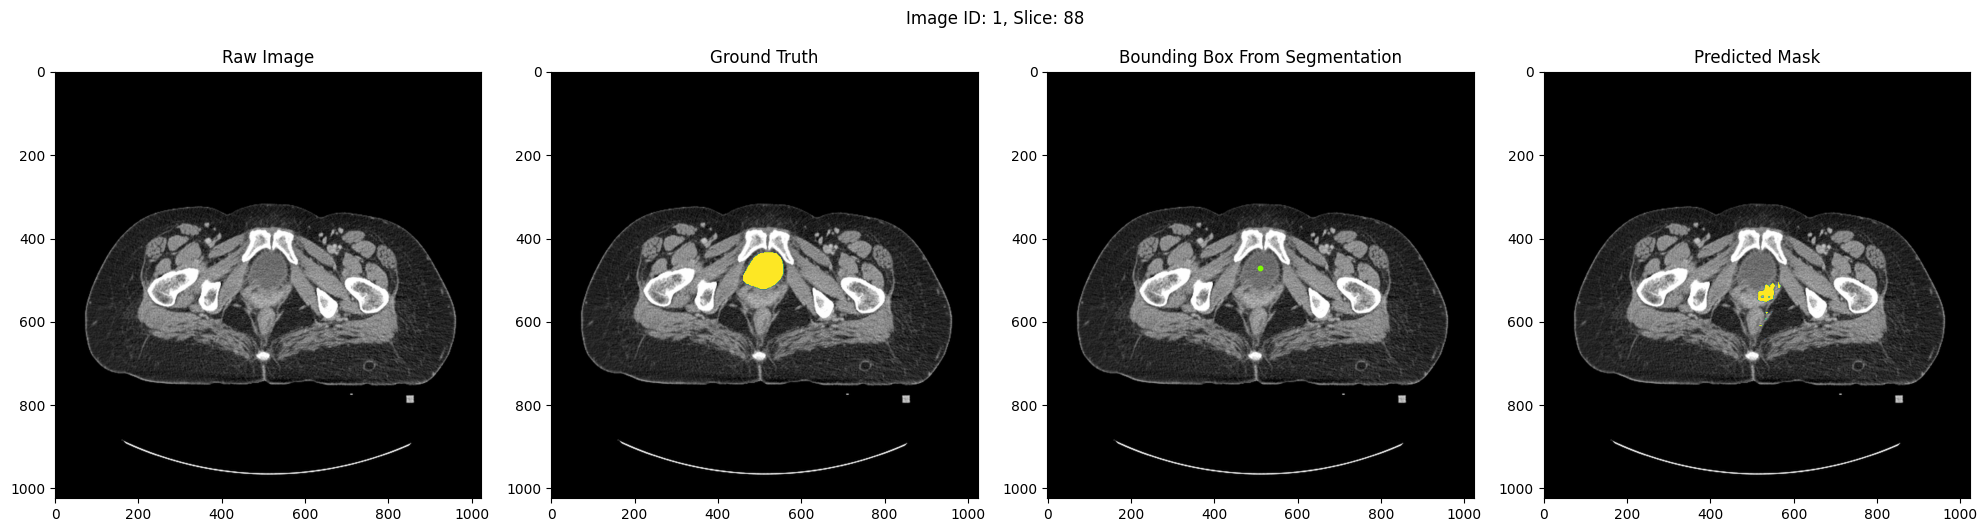

In [8]:
# Difficult Case
# exclude_points = np.array([[[500, 470],
#                             [570, 465],
#                             [555, 555]]])

# include_points = np.array([[[540, 500], [500, 400], [500, 550]]])

# Simple Case
include_points = np.array([[[510, 470]]])

medsam_prediction = medsam_inference(medsam_model
                                     , image_embedding
                                    #  , bounding_boxes
                                     , H, W
                                    #  , exclude_points=exclude_points
                                     , include_points=include_points
                                    ) 

visualise_bounding_box_with_prediction(array_image = image_slice_npy
                                       , array_gt_label = gt_slice_npy
                                       # , bounding_boxes = bounding_boxes
                                    #    , exclude_points = exclude_points
                                       , include_points = include_points
                                       , predicted_mask = medsam_prediction
                                       , show_boxes_of_predictions=False
                                       , sup_title=f"Image ID: {image_id}, Slice: {slice_id}")